In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get train and test data and convert them to data loaders
train_data = torchvision.datasets.MNIST('.', train = True, transform = transforms.ToTensor(), download = True)
test_data = torchvision.datasets.MNIST('.', train = False, transform = transforms.ToTensor(), download = True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [38]:
# check for cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = nn.Sequential(
    nn.Linear(784,256), # MNIST data is 28x28, so there'll be 784 input values for flatten image array. Unit number is 128 and it's an hyperparameter
    nn.ReLU(),
    nn.Linear(256, 10), # we have 10 output classes
    nn.LogSoftmax()
)

# pass model to GPU device in order to make computations faster
model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [26]:
import time

def train(model, train_loader, test_loader, n_epochs): # needs specified batch_size in loader
  train_losses = np.zeros(n_epochs)
  test_losses = np.zeros(n_epochs)

  for i in range(n_epochs):
    t0 = time.time()
    train_loss = []
    test_loss = []
    # train the model
    for inputs,targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device) # pass data to GPU
      inputs = inputs.view(-1, 784) # convert image array to flatten (,784) array
      
      # forward prop
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # back prop
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss.append(loss.item())

    # calculate the loss for test set
    for inputs,targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device) # pass data to GPU
      inputs = inputs.view(-1, 784) # convert image array to flatten (,784) array
      # forward prop
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())


    # calculate the average loss
    train_loss = np.mean(train_loss)
    test_loss = np.mean(test_loss)

    # save them to train_losses and test_losses
    train_losses[i] = train_loss
    test_losses[i] = test_loss

    t1 = time.time()
    print(f"Epoch {i+1}/{n_epochs} took {t1 - t0:.4f}s, train loss: {train_loss.item():.4f} | test loss : {test_loss.item():.4f}")
  return train_losses, test_losses 

def predict(model, data_loader):
  """
  Calculates loss and accuracy for given PyTorch data loader and PyTorch model.
  """
  losses = []
  n_correct = 0
  n_total = 0
  for inputs, targets in data_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    losses.append(loss.item())

    _, preds = torch.max(outputs, 1)
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0]

  acc = n_correct/n_total
  losses = np.array(losses).mean()
  return acc, losses

In [39]:
train_loss, test_loss = train(model, train_loader, test_loader, n_epochs = 10)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/10 took 6.9898s, train loss: 0.3616 | test loss : 0.1916
Epoch 2/10 took 7.0537s, train loss: 0.1576 | test loss : 0.1225
Epoch 3/10 took 7.1466s, train loss: 0.1065 | test loss : 0.0994
Epoch 4/10 took 7.0321s, train loss: 0.0790 | test loss : 0.0884
Epoch 5/10 took 7.1784s, train loss: 0.0620 | test loss : 0.0752
Epoch 6/10 took 7.1630s, train loss: 0.0491 | test loss : 0.0719
Epoch 7/10 took 7.1896s, train loss: 0.0393 | test loss : 0.0706
Epoch 8/10 took 7.1789s, train loss: 0.0315 | test loss : 0.0662
Epoch 9/10 took 7.1110s, train loss: 0.0259 | test loss : 0.0674
Epoch 10/10 took 7.1562s, train loss: 0.0211 | test loss : 0.0637


[]

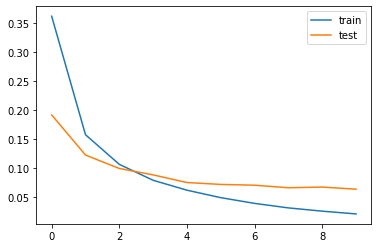

In [40]:
plt.plot(train_loss, label = 'train')
plt.plot(test_loss, label = 'test')
plt.legend()
plt.plot()

In [42]:
train_acc, _ = predict(model, test_loader)
test_acc,  _ = predict(model, train_loader)
print(f"Train accuracy: {train_acc:.4f}| Test accuracy: {test_acc:.4f}")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train accuracy: 0.9805| Test accuracy: 0.9969
